In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from pathlib import Path
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.linear_model import LinearRegression
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram
import datetime as dt


In [2]:
import os
print(os.getcwd())
pd.set_option('mode.chained_assignment', None)


C:\Users\Lena\Dokumente\GitHub\DataLiteracy


In [3]:
path = "Daten/data.csv"
df =  pd.read_csv(path,header=1, sep=";", names=['date','Tunnel','Steinlach','Hirschau'], parse_dates=['date']).dropna()
df['date']=pd.to_datetime(df['date']).dt.date
df=df.groupby(['date']).sum()


In [4]:
df_days = df.copy()
df_days.is_copy = True

df_weeks = df.copy()
df_weeks.is_copy = True

In [5]:
weeks = pd.date_range('2018-01-01', '2022-11-27', freq='W').to_numpy()
weeks= np.repeat(weeks, 7)

df_weeks['weekdate']= weeks.tolist()
df_weeks['weekdate']=pd.to_datetime(df_weeks['weekdate']).dt.date
df_weeks = df_weeks.groupby('weekdate').sum()

df_weeks.index = pd.to_datetime(df_weeks.index)
df_weeks['week'] = df_weeks.index.week
df_weeks['year'] = df_weeks.index.year

df_weeks

C:\Users\Lena\AppData\Local\Temp\ipykernel_15468\3009910297.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_weeks['week'] = df_weeks.index.week


,Tunnel,Steinlach,Hirschau,week,year
weekdate,,,,,
2018-01-07,19002,30213,4812,1,2018
2018-01-14,19946,29657,3793,2,2018
2018-01-21,16793,15439,1707,3,2018
2018-01-28,20033,41665,2771,4,2018
2018-02-04,19313,35519,3145,5,2018
...,...,...,...,...,...
2022-10-30,35489,56452,8947,43,2022
2022-11-06,32135,59687,5642,44,2022
2022-11-13,27390,52318,4194,45,2022


In [6]:
df_days.index = pd.to_datetime(df_days.index)
df_days['day'] = df_days.index.dayofweek
df_days['week'] = df_days.index.week
df_days['dayofyear'] = df_days.index.dayofyear
df_days['year'] = df_days.index.year

df_days

C:\Users\Lena\AppData\Local\Temp\ipykernel_15468\1664613430.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_days['week'] = df_days.index.week


,Tunnel,Steinlach,Hirschau,day,week,dayofyear,year
date,,,,,,,
2018-01-01,721,0,184,0,1,1,2018
2018-01-02,2836,6130,331,1,1,2,2018
2018-01-03,2465,4742,216,2,1,3,2018
2018-01-04,733,1220,111,3,1,4,2018
2018-01-05,2841,4471,1129,4,1,5,2018
...,...,...,...,...,...,...,...
2022-12-07,6952,11780,1621,2,49,341,2022
2022-12-08,4873,7554,1231,3,49,342,2022
2022-12-09,6371,10101,1532,4,49,343,2022


In [18]:
#create train and test dataframes
days_train = df_days.copy()
days_train.is_copy = True

days_to_drop = df_days[df_days['year'] == 2022].index
days_train = days_train.drop(days_to_drop)


weeks_train = df_weeks.copy()
weeks_train.is_copy = True

weeks_to_drop = df_weeks[df_weeks['year'] == 2022].index
weeks_train = weeks_train.drop(weeks_to_drop)

weeks_train

,Tunnel,Steinlach,Hirschau,week,year
weekdate,,,,,
2018-01-07,19002,30213,4812,1,2018
2018-01-14,19946,29657,3793,2,2018
2018-01-21,16793,15439,1707,3,2018
2018-01-28,20033,41665,2771,4,2018
2018-02-04,19313,35519,3145,5,2018
...,...,...,...,...,...
2021-11-28,22737,44481,3383,47,2021
2021-12-05,19800,34570,1986,48,2021
2021-12-12,31974,47506,6607,49,2021


In [8]:
#this is stolen from https://www.kaggle.com/code/ryanholbrook/seasonality
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

<AxesSubplot:title={'center':'Seasonal Plot (year/week)'}, xlabel='week', ylabel='Tunnel'>

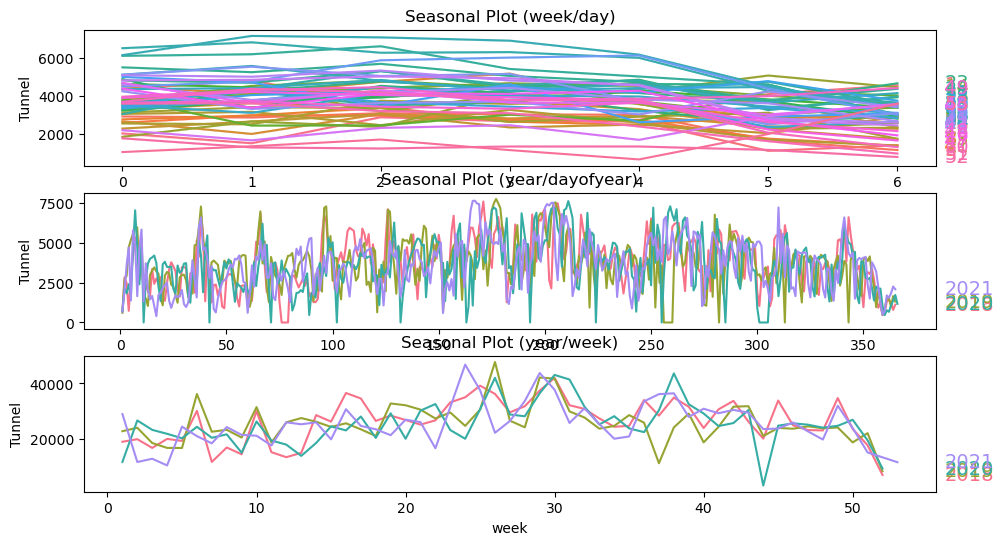

In [20]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(11, 6))
seasonal_plot(days_train, y="Tunnel", period="week", freq="day", ax=ax0)
seasonal_plot(days_train, y="Tunnel", period="year", freq="dayofyear", ax=ax1)
seasonal_plot(weeks_train, y="Tunnel", period="year", freq="week", ax=ax2)

In [48]:
dp_days = DeterministicProcess(
    index=days_train.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    seasonal=True,
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
Xdays = dp_days.in_sample()
Xdays = Xdays.drop(['trend'], axis=1)

Xdays.head()

dp_weeks = DeterministicProcess(
    index=weeks_train.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    seasonal=True,
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
Xweeks = dp_weeks.in_sample()
Xweeks = Xweeks.drop(['trend'], axis=1)

Xweeks.head()

,const,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)","s(9,52)","s(10,52)",...,"s(43,52)","s(44,52)","s(45,52)","s(46,52)","s(47,52)","s(48,52)","s(49,52)","s(50,52)","s(51,52)","s(52,52)"
weekdate,,,,,,,,,,,,,,,,,,,,,
2018-01-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-14,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-21,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-28,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-02-04,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
model_days = LinearRegression(fit_intercept=False)
_ = model_days.fit(Xdays, days_train['Tunnel'])

y_pred_days = pd.Series(model_days.predict(Xdays), index=days_train['Tunnel'].index)

display(y_pred_days)


model_weeks = LinearRegression(fit_intercept=False)
_ = model_weeks.fit(Xweeks, weeks_train['Tunnel'])

y_pred_weeks = pd.Series(model_weeks.predict(Xweeks), index=weeks_train['Tunnel'].index)

display(y_pred_weeks)


date
2018-01-01    3856.933014
2018-01-02    3946.722488
2018-01-03    4080.961722
2018-01-04    3988.827751
2018-01-05    3765.483254
                 ...     
2021-12-27    3856.933014
2021-12-28    3946.722488
2021-12-29    4080.961722
2021-12-30    3988.827751
2021-12-31    3765.483254
Length: 1461, dtype: float64

weekdate
2018-01-07    16306.00
2018-01-14    24906.75
2018-01-21    17591.00
2018-01-28    17898.75
2018-02-04    16712.75
                ...   
2021-11-28    23438.25
2021-12-05    25860.50
2021-12-12    25319.50
2021-12-19    20829.25
2021-12-26    10030.75
Length: 208, dtype: float64

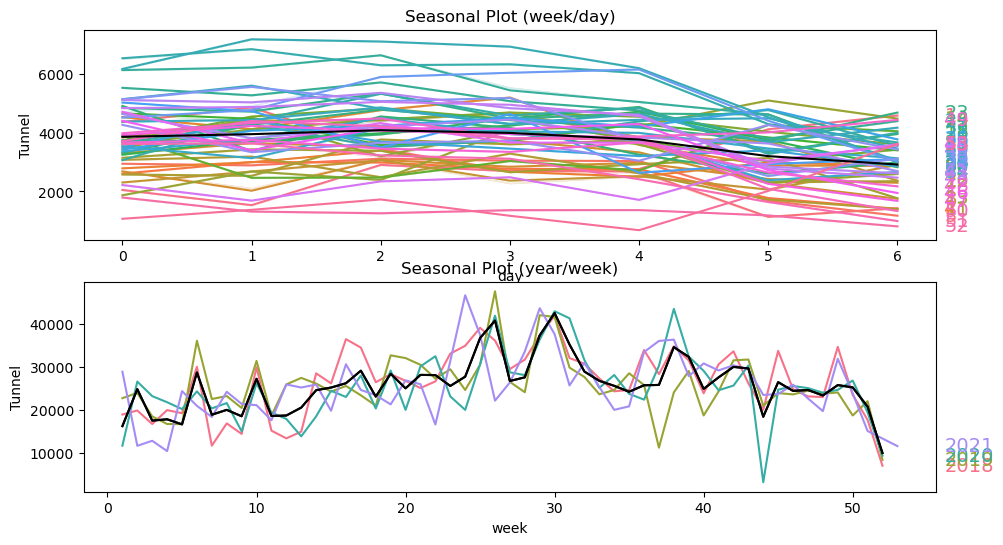

In [57]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(days_train, y="Tunnel", period="week", freq="day", ax=ax0)
ax0.plot(range(7),y_pred_days[:7], color='black')

seasonal_plot(weeks_train, y="Tunnel", period="year", freq="week", ax=ax1)
ax1.plot(range(1,53), y_pred_weeks[:52], color='black')
ax1.plot(range(1,53), y_pred_weeks[52:104], color='black')